### ollama 모델 활용

In [ ]:
import base64
from io import BytesIO
from IPython.display import HTML, display
from PIL import Image

from langchain_core.messages import HumanMessage



def convert_to_base64(pil_image):
    buffer = BytesIO()
    pil_image.save(buffer, format='jpeg')
    img_str = base64.b64encode(buffer.getvalue()).decode('utf-8')
    return img_str


def plt_img_base64(img_base64):  # 클라이언트와의 통신을 위해 바이너리 타입을 스트링으로 변환하여 전송함
    image = f'<img src="data:image/jpeg;base64,{img_base64}">'
    display(HTML(image))
    
    
def make_prompt(data):
    text = data['text']
    image = data['image']
    
    image_data = {
        'type': 'image_url',
        'image_url': f"data:image/jpeg;base64,{image}"
    }
    
    text_data = {
        'type': 'text',
        'text': text
    }
    
    content_data = []
    content_data.append(image_data)
    content_data.append(text_data)
    
    return [HumanMessage(content=content_data)]



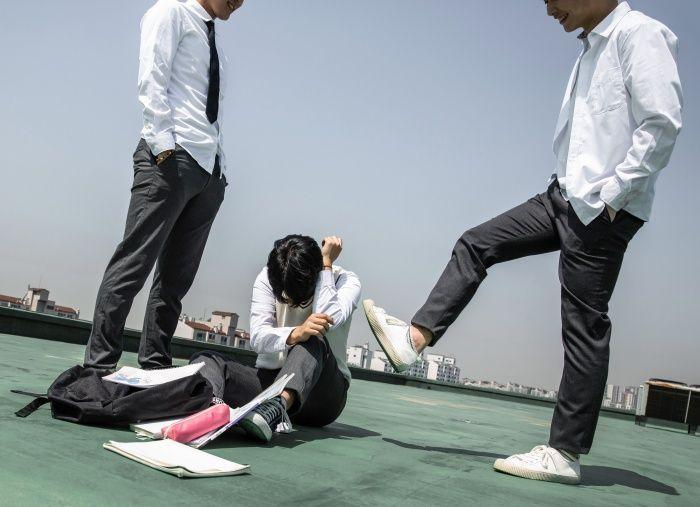

In [ ]:
image = Image.open('data/fight.jpeg')
plt_img_base64(convert_to_base64(image))

In [15]:
from langchain_core.output_parsers import StrOutputParser
from langchain_community.chat_models import ChatOllama
from langchain_core.messages import HumanMessage

llm = ChatOllama(
    model="bakllava",
    temperature=0,
)

image = Image.open('data/fight.jpeg')

chain = make_prompt | llm | StrOutputParser()

response = chain.invoke(
    {
        # 'text': 'If there is a violent scene in the image, output "Danger", otherwise output "Safe"',
        'text': 'Describe a picture in bullet pionts',
        'image': convert_to_base64(image)
    }
)

response

'1. Three men are standing on a roof, two of them wearing ties and one wearing a t-shirt. They appear to be looking at something on the ground.\n2. The man wearing the t-shirt is sitting down with his legs crossed, while the other two men stand above him.\n3. There are several buildings in the background, indicating that they might be in an urban setting.\n4. A backpack and a book can be seen near the man sitting on the ground, suggesting that they may have been engaged in some outdoor activity or discussion prior to this moment.'

In [17]:
from dotenv import load_dotenv
load_dotenv()

from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

template = "{picture}에서 여러명의 사람이 발견되었으면 '위험' 그렇지 않으면 '안전'을 출력해 주세요"
llm_prompt = PromptTemplate.from_template(template)

llm_openai = ChatOpenAI(model_name='gpt-4o-mini')
picture_chain = make_prompt | llm | StrOutputParser() | llm_prompt | llm_openai



picture_chain.invoke(
    {
        # 'text': 'If there is a violent scene in the image, output "Danger", otherwise output "Safe"',
        'text': 'Describe a picture in bullet pionts',
        'image': convert_to_base64(image)
    }
)

AIMessage(content='위험', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 3, 'prompt_tokens': 98, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-66a52f3f-699d-4d90-bb0f-dbd28377b77a-0', usage_metadata={'input_tokens': 98, 'output_tokens': 3, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### gemini api 활용
#### 이미지

In [18]:
from dotenv import load_dotenv
load_dotenv()

True

In [21]:
# 이미지 업로드
import google.generativeai as genai
import time

img_file = genai.upload_file(path='data/cat.jpg')
time.sleep(5)

img_info = genai.get_file(img_file.name)
# print(img_info)

prompt = '이미지에서 폭력적인 장면이 나오면 "위험" 그렇지 않다면 "안전"을 출력하세요'

model = genai.GenerativeModel(
    model_name='models/gemini-1.5-flash'
)

response = model.generate_content(
    contents=[prompt, img_info],
    request_options={'timeout': 100}
)

print(response)
print(response.text)

genai.File({
    'name': 'files/uzq1wiy3xr9o',
    'display_name': 'cat.jpg',
    'mime_type': 'image/jpeg',
    'sha256_hash': 'ZDVjMjM3OWZlOWM5NTQzYmUxMjlkMTJjYWVhM2NjMjQ3YmI5ZThkZWQwNzdkOTBjNzQ0NGMwYTY4YTcxMWQxOA==',
    'size_bytes': '45194',
    'state': 'ACTIVE',
    'uri': 'https://generativelanguage.googleapis.com/v1beta/files/uzq1wiy3xr9o',
    'create_time': '2025-03-11T02:52:25.821143Z',
    'expiration_time': '2025-03-13T02:52:25.811000338Z',
    'update_time': '2025-03-11T02:52:25.821143Z'})
response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "\uc548\uc804"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "avg_logprobs": -0.00010249923070659861
        }
      ],
      "usage_metadata": {
        "prompt_token_count": 289,
       

#### 영상

In [25]:
# 영상 업로드
import google.generativeai as genai
import time

video_file = genai.upload_file(path='data/videodata.mp4')

while genai.get_file(video_file.name).state != 2:
    print(genai.get_file(video_file.name).state)
    print("업로드 대기중")
    time.sleep(5)

video_info = genai.get_file(video_file.name)
# print(img_info)

prompt = '이 영상에 대해 요약해주세요.'

model = genai.GenerativeModel(
    model_name='models/gemini-1.5-flash'
)

response = model.generate_content(
    contents=[prompt, video_info],
    request_options={'timeout': 300}
)

print(response)
print(response.text)

1
업로드 대기중
1
업로드 대기중
response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "\uc774 \uc601\uc0c1\uc740 \uc720\ud29c\ubc84 \ud478\ud478\ub9ac\uac00 \ud63c\uc790\uc11c \uc548\ub3d9\ucc1c\ub2ed\uc744 \uba39\ubc29\ud558\ub294 \uc601\uc0c1\uc785\ub2c8\ub2e4.\n\n\uc601\uc0c1 \ucd08\ubc18 \ud478\ud478\ub9ac\ub294 \uc2dc\uccad\uc790\uc758 \uc9c8\ubb38\uc5d0 \ub2f5\ud558\uba70 \uc548\ub3d9\ucc1c\ub2ed\uacfc \ubc30\uc6b0 \uae40\ud61c\uc218\ub97c \ube44\uad50\ud558\ub294\ub370, \uc548\ub3d9\ucc1c\ub2ed\uc744 \uba39\ub294 \ud478\ud478\ub9ac\uc758 \ud45c\uc815\uc774 \uae40\ud61c\uc218\uc640 \ub2ee\uc558\ub2e4\ub294 \ub0b4\uc6a9\uc785\ub2c8\ub2e4.\n\n\uc774\uc5b4\uc11c \uadf8\ub294 1\uc778\ubd84\uc5d0 15000\uc6d0\uc9dc\ub9ac \uc548\ub3d9\ucc1c\ub2ed\uc744 \uba39\uc73c\uba70, \uc5ec\ub7ec \uac00\uc9c0 \uc0dd\uac01\uc744 \uc774\u